In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.signal import find_peaks

np.random.seed(42)

In [2]:
DATA_DIR_PATH = '../data'

In [3]:
def plot_against_date(
    df, ycols, title, xlabel="Date", ylabel=None, kind='line',
    legend=True, legend_labels=None, figsize=(15, 6), grid=True
):
    """
    Helper to plot columns against a date index or 'date' column.
    - df: DataFrame to plot from
    - ycols: list of columns to plot
    - title: plot title
    - xlabel, ylabel: axis labels
    - kind: 'line' or 'area'
    - legend: show legend
    - legend_labels: custom list of legend labels (optional)
    - figsize: figure size
    - grid: show grid
    """
    plt.figure(figsize=figsize)
    x = df.index if 'date' not in df.columns else df['date']
    if kind == 'area':
        labels = legend_labels if legend_labels is not None else ycols
        plt.stackplot(x, [df[col] for col in ycols], labels=labels)
    else:
        for i, col in enumerate(ycols):
            label = legend_labels[i] if legend_labels is not None else col
            plt.plot(x, df[col], label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if legend:
        plt.legend()
    if grid:
        plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
#  --- 1. VARIANT DATA (GISAID) ---

# Source: https://gisaid.org (Excel file with variant statistics)
xl = pd.ExcelFile(f'{DATA_DIR_PATH}/gisaid_variants_statistics_2022_10_17_1253.xlsx')

# Extract and combine variant data for Canada from each sheet
first_flag = True
for sheet_name in xl.sheet_names[1:]:
    df = xl.parse(sheet_name)
    df_var = df[df.iloc[:, 0] == 'Canada']
    df_var = df_var.iloc[:, 2:].T
    # Clean up column names
    df_var.rename(columns={df_var.columns[0]: sheet_name.replace('VOI', '').replace('VOC', '').strip()}, inplace=True)
    if first_flag:
        df_all = df_var.copy()
        first_flag = False
    else:
        df_all = df_all.join(df_var)

# Fill missing values with 0, set index as datetime, and add a 'total' column
df_all.fillna(0, inplace=True)
df_all.index = pd.to_datetime(df_all.index)
df_all['Total'] = df_all.sum(axis=1)



In [5]:
df_all.head()

,Omicron,Delta,Alpha,Beta,Gamma,Epsilon,Zeta,Eta,Theta,Iota,Kappa,Lambda,Total
2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


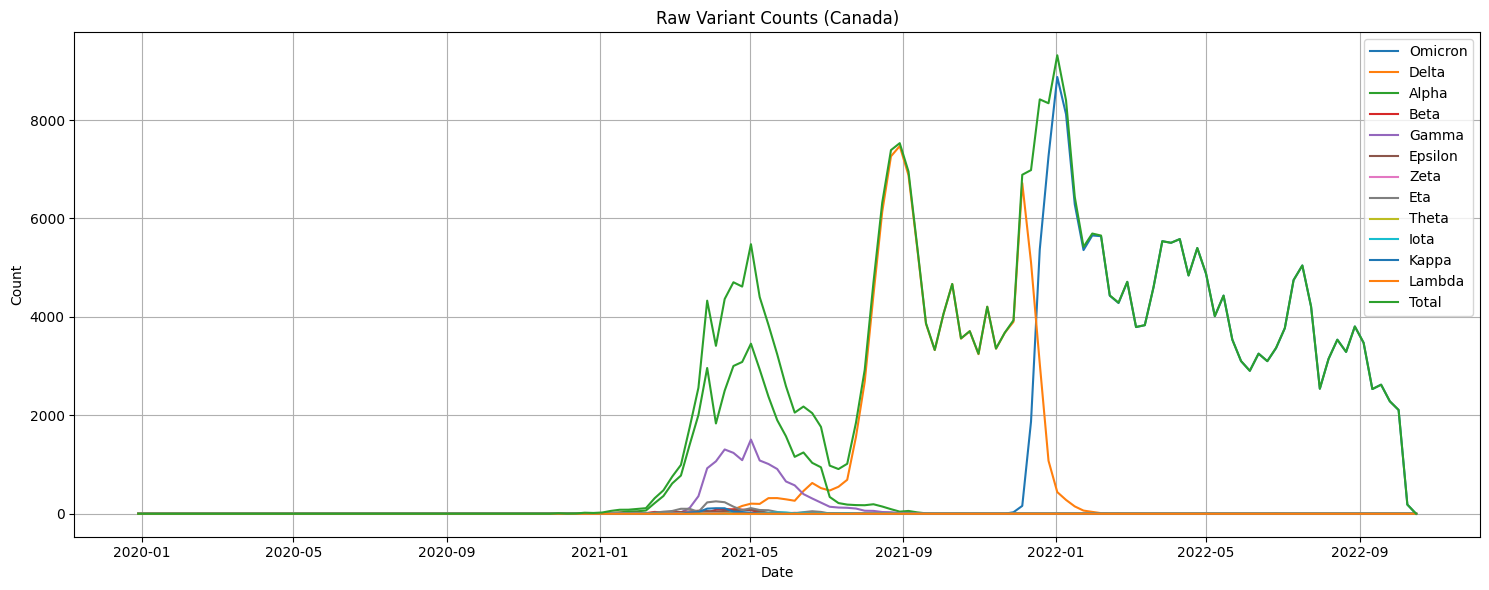

In [6]:
plot_against_date(df_all, df_all.columns, "Raw Variant Counts (Canada)", ylabel="Count")

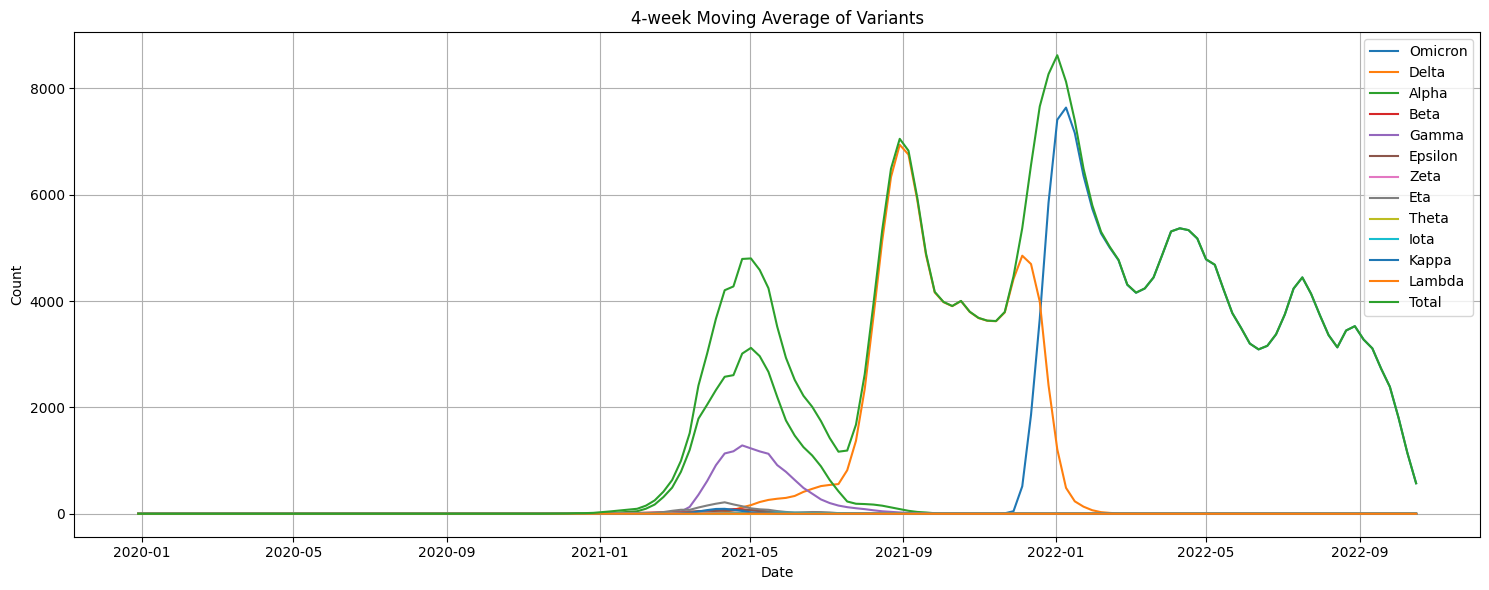

In [7]:
# --- 4-week Moving Average for Variants ---
df_all_avg = df_all.copy()
for col in df_all_avg.columns:
    df_all_avg[col] = uniform_filter1d(df_all_avg[col], size=4).reshape(-1, 1)
plot_against_date(df_all_avg, df_all_avg.columns, "4-week Moving Average of Variants", ylabel="Count")

df_all_avg.to_csv(f'{DATA_DIR_PATH}/canada_variant_weekly_4w_avg.csv')

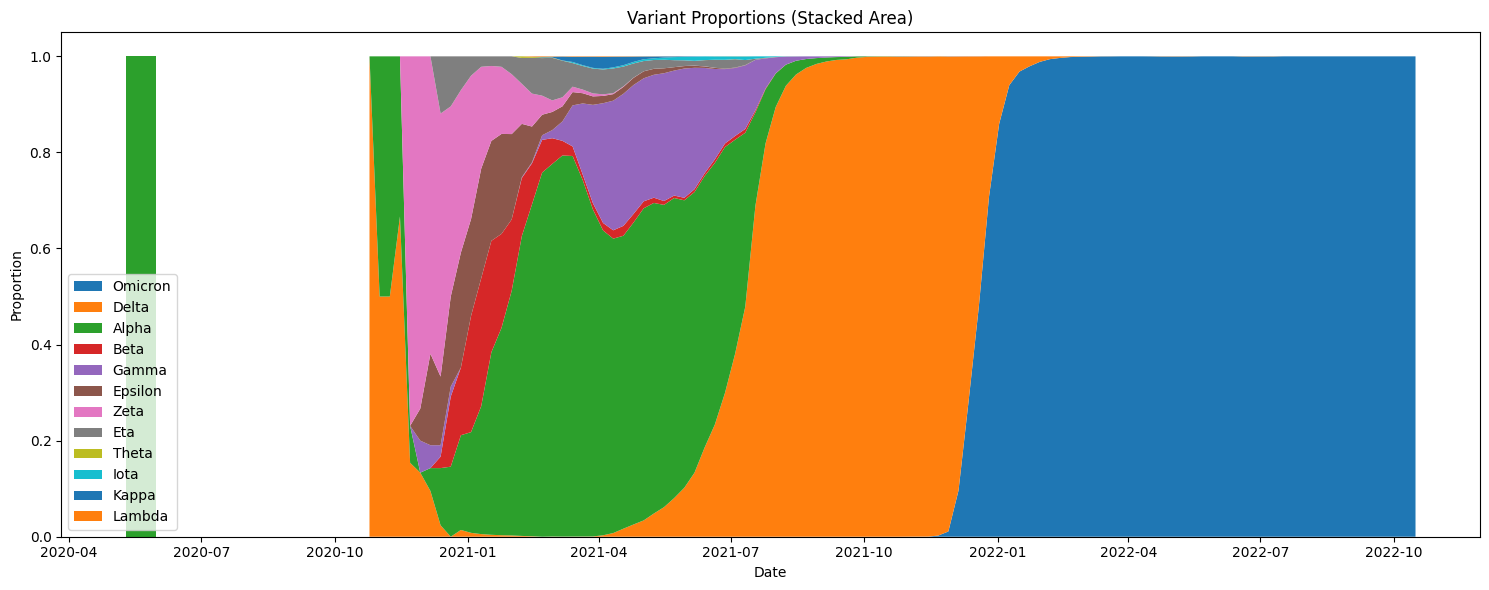

In [8]:
# --- Normalized Variant Proportions (Stacked Area Plot) ---
df_norm = df_all_avg.copy()
df_norm = df_norm.div(df_norm['Total'], axis=0)
df_norm.drop('Total', axis=1, inplace=True)
plot_against_date(df_norm, df_norm.columns, "Variant Proportions (Stacked Area)", kind='area', ylabel="Proportion", grid=False)

In [9]:
# --- 2. PROVINCIAL CASE DATA (JHU CSSE) ---

# Source: Johns Hopkins University CSSE COVID-19 Data Repository
# https://github.com/CSSEGISandData/COVID-19
df = pd.read_csv(f'{DATA_DIR_PATH}/time_series_covid19_confirmed_global.csv')

# Filter for Canada and remove cruise ships
df_can = df[df['Country/Region'] == 'Canada']
df_can = df_can[~df_can['Province/State'].isin(['Repatriated Travellers', 'Diamond Princess', 'Grand Princess'])]

df_can = df_can.drop(['Country/Region', 'Lat', 'Long'], axis=1)
df_can.rename({'Province/State': 'date'}, axis=1, inplace=True)
df_can = df_can.pivot_table(columns=['date'])
df_can.index = pd.to_datetime(df_can.index)
df_can.sort_index(inplace=True)
df_can['Total'] = df_can.sum(axis=1)

# Check for negative values
print("Negative values in provincial data:", (df_can < 0).sum().sum())

Negative values in provincial data: 0


/var/folders/jz/tkf4m4zn5z55yk7x24vrmf8h0000gn/T/ipykernel_5342/773386826.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_can.index = pd.to_datetime(df_can.index)


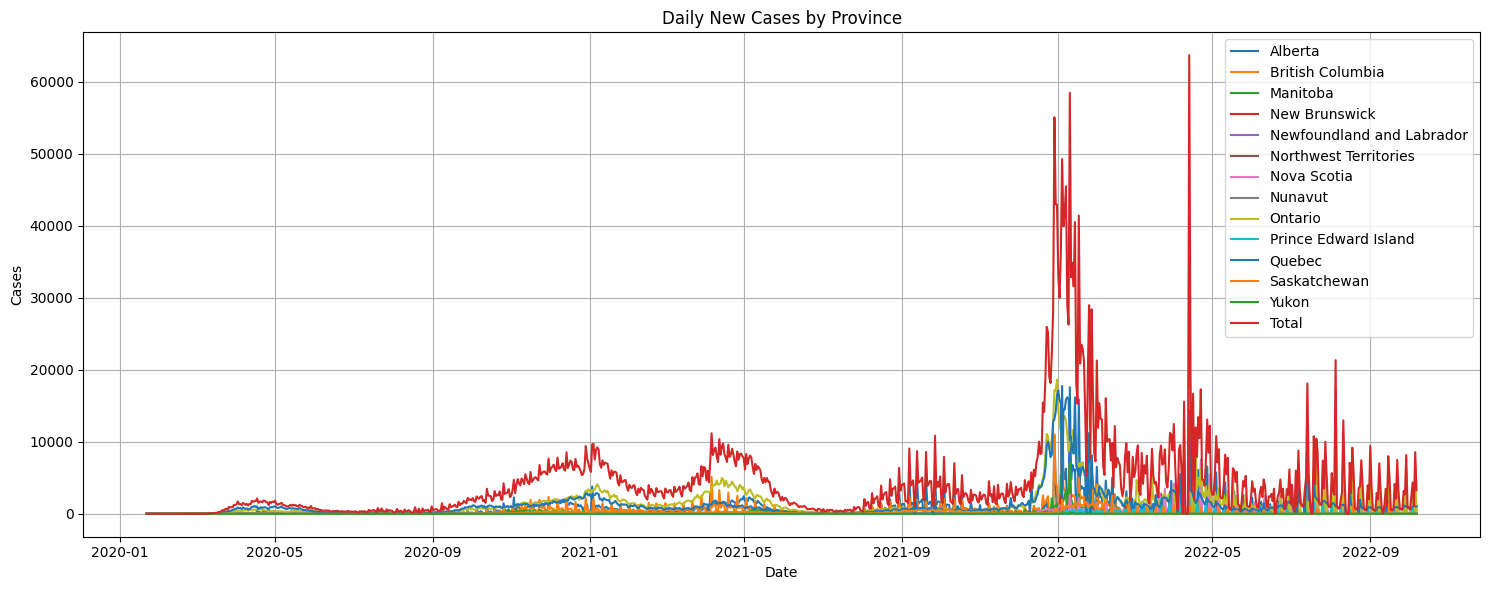

In [ ]:

# --- Convert Cumulative to Daily Cases ---
df_can2 = df_can - df_can.shift(1).fillna(0)
df_can2.drop('Total', axis=1, inplace=True)
df_can2[df_can2 < 0] = 0  # Remove any negative daily counts
df_can2['Total'] = df_can2.sum(axis=1)
plot_against_date(df_can2, df_can2.columns, "Daily New Cases by Province", ylabel="Cases")

# Save daily new cases
df_can2.to_csv(f'{DATA_DIR_PATH}/canada_regional.csv')

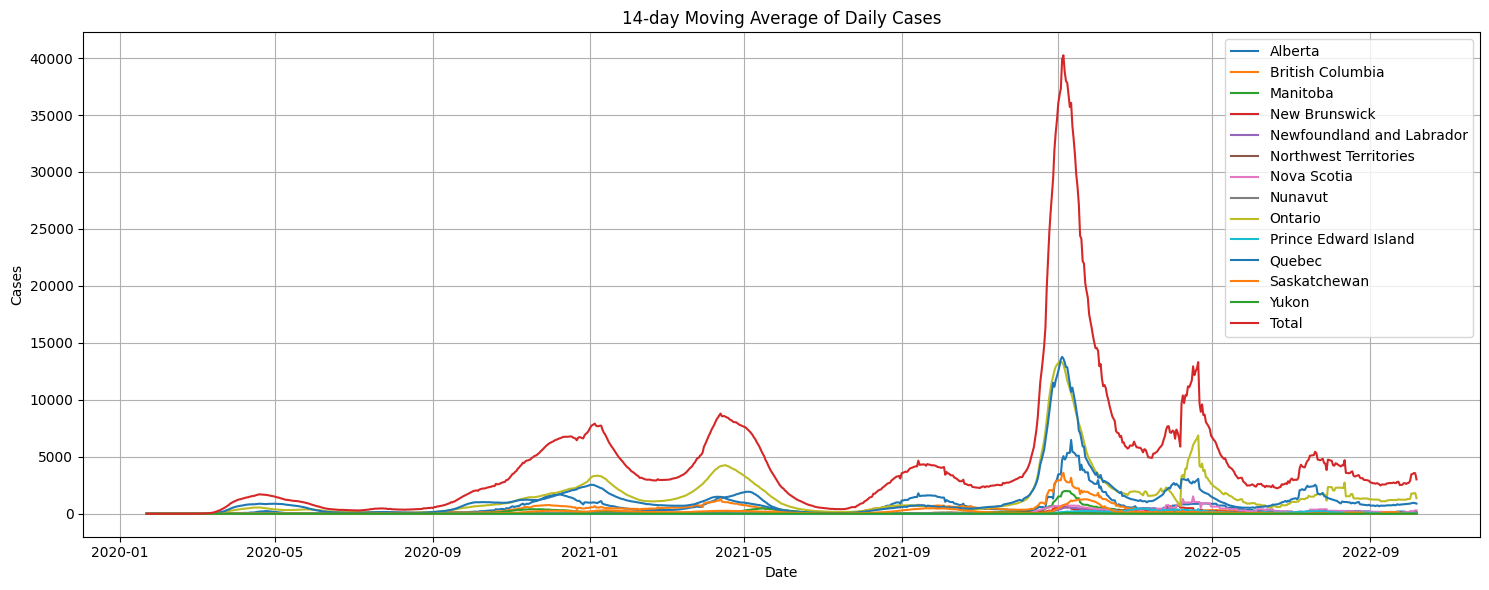

In [11]:
# --- 14-day Moving Average for Provinces ---
df_can_avg = df_can2.copy()
for col in df_can_avg.columns:
    df_can_avg[col] = uniform_filter1d(df_can_avg[col], size=14).reshape(-1, 1)
plot_against_date(df_can_avg, df_can_avg.columns, "14-day Moving Average of Daily Cases", ylabel="Cases")

# Save the smoothed provincial data
df_can_avg.to_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg.csv')

In [12]:
# --- 3. NATIONAL CASES, HOSPITALIZATIONS, DEATHS (OWID) ---

# Source: Our World In Data (OWID)
df_owid = pd.read_csv(f'{DATA_DIR_PATH}/owid-covid-data.csv')

# Filter for Canada and reset index
df_owid_can = df_owid[df_owid['location'] == 'Canada'].copy()
df_owid_can.reset_index(inplace=True)
df_owid_can['date'] = pd.to_datetime(df_owid_can['date'])

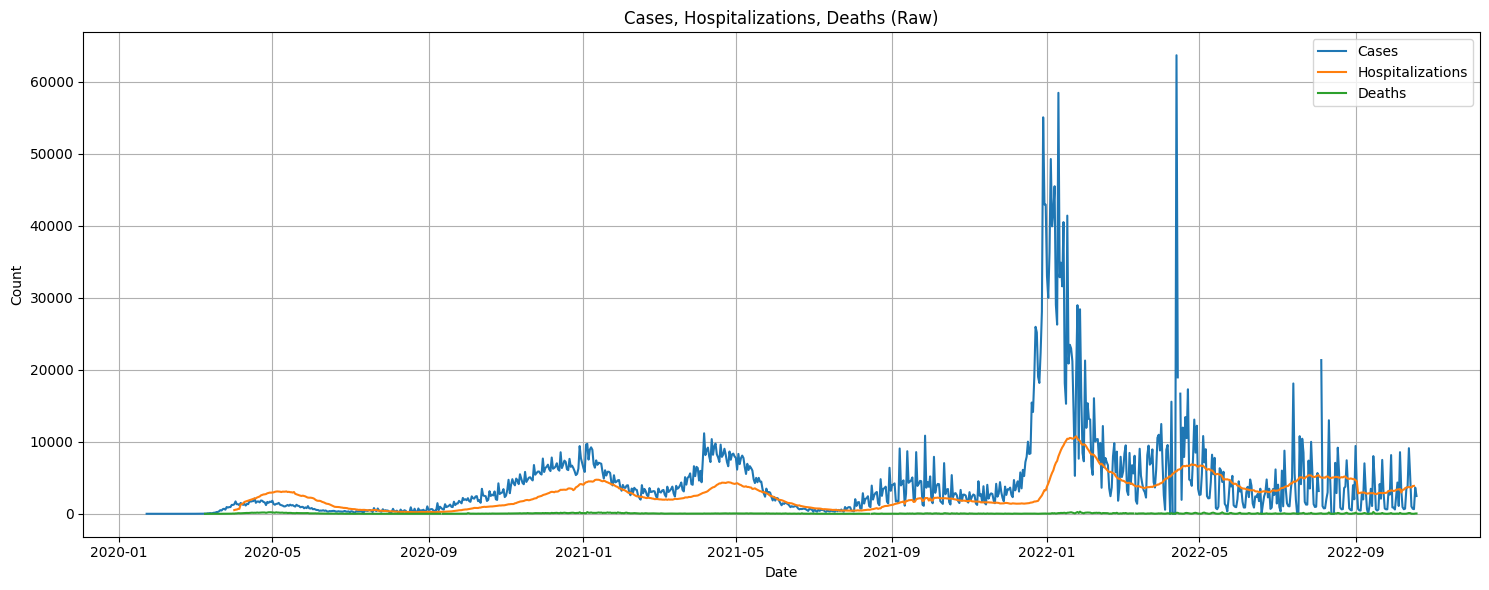

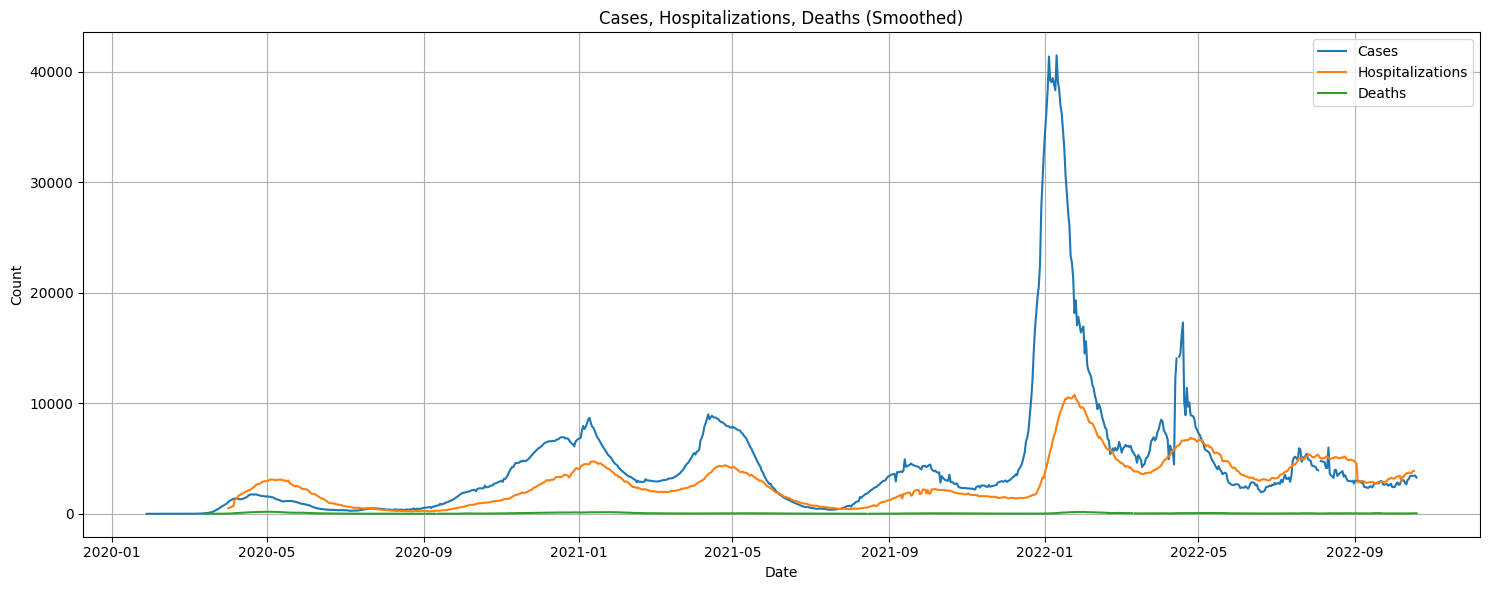

In [13]:
# Plot cases, hospitalizations, and deaths (raw and smoothed)
plot_against_date(df_owid_can, ['new_cases', 'hosp_patients', 'new_deaths'], "Cases, Hospitalizations, Deaths (Raw)", ylabel="Count", legend_labels=['Cases', 'Hospitalizations', 'Deaths'])

plot_against_date(df_owid_can, ['new_cases_smoothed', 'hosp_patients', 'new_deaths_smoothed'], "Cases, Hospitalizations, Deaths (Smoothed)", ylabel="Count", legend_labels=['Cases', 'Hospitalizations', 'Deaths'])


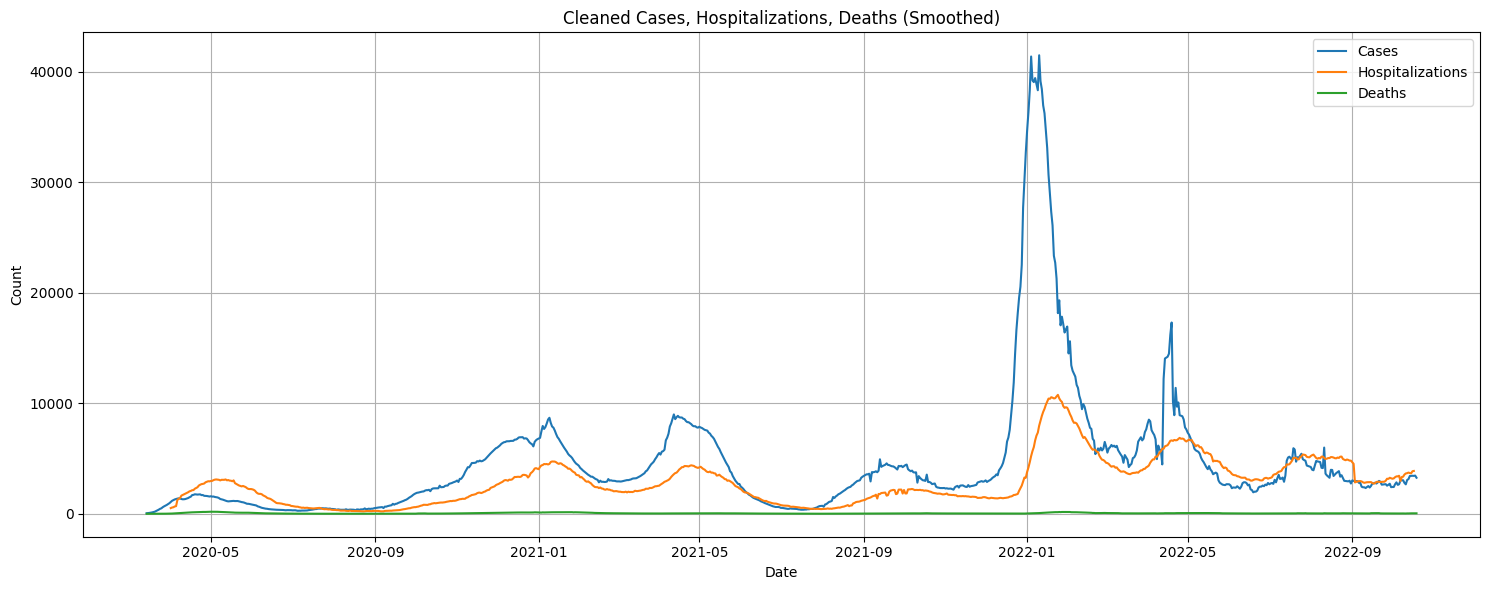

In [14]:
# --- Prepare a Cleaned DataFrame for Lag Analysis ---
df_small = df_owid_can[['date', 'new_cases_smoothed', 'hosp_patients', 'new_deaths_smoothed']].copy()
df_small = df_small.dropna(subset=['new_cases_smoothed', 'new_deaths_smoothed'])
df_small.reset_index(inplace=True)

plot_against_date(
    df_small,
    ['new_cases_smoothed', 'hosp_patients', 'new_deaths_smoothed'],
    "Cleaned Cases, Hospitalizations, Deaths (Smoothed)",
    ylabel="Count",
    legend_labels=['Cases', 'Hospitalizations', 'Deaths']
)

Text(0.5, 1.0, 'Peaks in Cases and Hospitalizations')

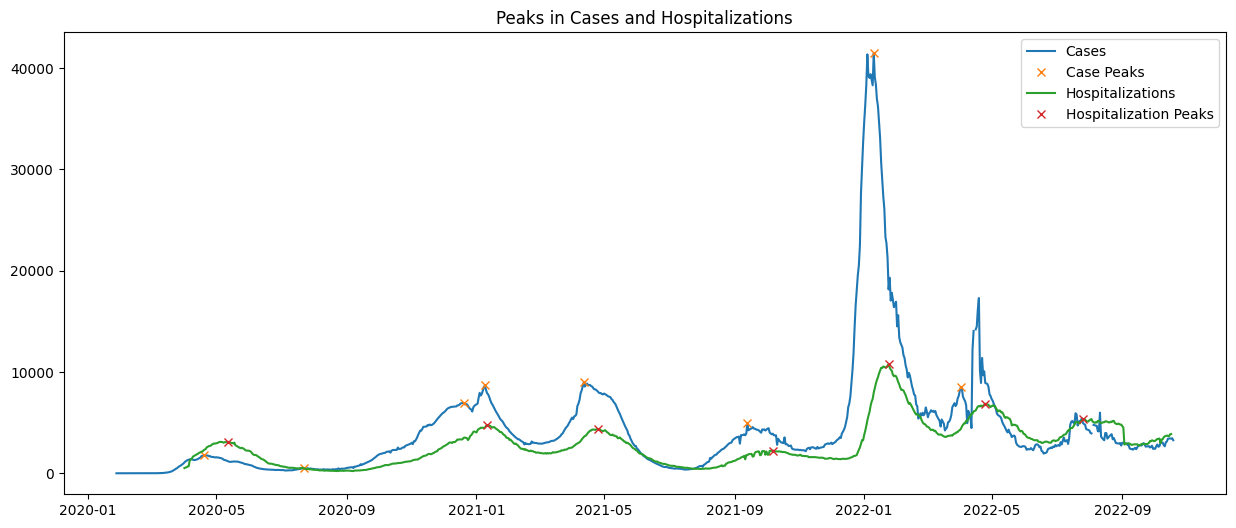

In [15]:
# --- Peak Detection and Lag Calculation ---
cases_peaks, _ = find_peaks(x=df_owid_can['new_cases_smoothed'], prominence=1, width=8)
hosp_peaks, _ = find_peaks(x=df_owid_can['hosp_patients'], prominence=1, width=8)

plt.figure(figsize=(15, 6))
plt.plot(df_owid_can['date'], df_owid_can['new_cases_smoothed'])
plt.plot(df_owid_can.loc[cases_peaks, 'date'], df_owid_can.loc[cases_peaks, 'new_cases_smoothed'], 'x')
plt.plot(df_owid_can['date'], df_owid_can['hosp_patients'])
plt.plot(df_owid_can.loc[hosp_peaks, 'date'], df_owid_can.loc[hosp_peaks, 'hosp_patients'], 'x')
plt.legend(['Cases', 'Case Peaks', 'Hospitalizations', 'Hospitalization Peaks'])
plt.title("Peaks in Cases and Hospitalizations")

In [16]:
total_lag = 0
for x in hosp_peaks[:-1]:
    diffs = x - cases_peaks
    total_lag += min(diffs[diffs > 2])
print('Average lag (days) between case and hospitalization peaks:', total_lag / (len(hosp_peaks)-1))


Average lag (days) between case and hospitalization peaks: 19.833333333333332
